# Library

In [111]:
import pandas as pd
import numpy as np
import os
import re
import collections
import unidecode
import nltk
from nltk.corpus import stopwords
import itertools 
from nltk.tokenize import word_tokenize
from string import punctuation
from functools import reduce

In [112]:
pd.set_option('display.max_colwidth', 100)

In [113]:
%matplotlib inline
from matplotlib import pyplot as plt

# Functions

In [114]:
def read_texts(path):
    data = []
    file_name = os.listdir(path)

    for name in file_name:
        if name.endswith('.txt'):
            with open(path + name,encoding="utf8") as f:
                text = f.read()
                data.append({'nombre':name.replace('.txt',''), 'texto':text})

    df = pd.DataFrame(data)
    return df

In [115]:
def clean_text(string):
    """
    A method to clean text 
    """
    
    # Removing the punctuations
    for x in string.lower(): 
        if x in punctuation:
            if x != '/':
                string = string.replace(x, "")
            else:
                string = string.replace(x, " ")
    
    string = unidecode.unidecode(string)

#     # Converting the text to lower
#     string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in swords])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string 

In [116]:
nltk.download('stopwords')
swords = list(set(stopwords.words('spanish')))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/egarcia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [117]:
def sep_num_text(data):

    words = word_tokenize(data) 
    for w in words:
        if re.search(r'\d', w):
            ind = words.index(w)
            words[ind] = [''.join(g) for k, g in itertools.groupby(w, str.isalpha)]
    data = ' '.join([x if type(x) is not list else ' '.join(x) for x in words])
    
    return data

In [118]:
def get_f_b_context_text(data):
    
    '''Return context in a string format'''
    
    all_data = []
    sf_not_found = []
    
    for instance in data:
           
        texto = instance['texto']    
        target_word = instance['short_form'] 
        
        if target_word in texto:

            stop_ini_idx = instance['StartOffset'] #índice del inicio de la target
            stop_fin_idx = instance['EndOffset'] #índice del inicio de la target

            _instance = []
            xf = texto[:stop_ini_idx] + ' <start> ' +texto[stop_ini_idx:stop_fin_idx] + ' <end> ' #palabras anteriores a la target
            #xf = texto[:stop_ini_idx] +texto[stop_ini_idx:stop_fin_idx]
            xb = texto[stop_fin_idx+1:]   #palabras posteriores a la target            

            instance_id = instance['long_form'] #id del significado

            _instance.append(target_word)
            _instance.append(xf)
            _instance.append(xb)
            _instance.append(instance_id)

            all_data.append(_instance[:])
        else:
            sf_not_found.append(target_word)
#             print("El acrónimo {} no aparece en el texto {}".format(target_word, instance['doc_id']))
        
    return all_data, sf_not_found

In [119]:
def limit_context(data):

    for doc in data:
        
        sf, xf, xb, lf = doc[0], doc[1], doc[2], doc[3]

        xf_words = word_tokenize(xf)[-n_step_f-1:]
        xb_words = word_tokenize(xb)[:n_step_b]

        doc[1] = ' '.join(xf_words)
        doc[2] = ' '.join(xb_words)   

    return data        

In [120]:
def create_dict(data):
    
    data_dic = []
    
    for instance in data:
            
        dic = {}

        dic['short_form'] = instance[0]
        dic['context'] = instance[1] + ' ' + instance[2]
        dic['long_form'] = instance[3]
    
        data_dic.append(dic)
        
    return data_dic
    

In [121]:
def distance_levenshtein(str1, str2):
    d=dict()
    for i in range(len(str1)+1):
        d[i]=dict()
        d[i][0]=i
    for i in range(len(str2)+1):
        d[0][i] = i
    for i in range(1, len(str1)+1):
        for j in range(1, len(str2)+1):
            d[i][j] = min(d[i][j-1]+1, d[i-1][j]+1, d[i-1][j-1]+(not str1[i-1] == str2[j-1]))
    return d[len(str1)][len(str2)]

In [122]:
def normalize_lf(row):
    leven2 = []
    for i in row:
        for j in row:
            if i != j:
                long = max(len(i),len(j))
                ratio = distance_levenshtein(i,j)/long
                if ratio < 0.2:
                    leven2.append(j)
    if leven2:
        leven2 = set(leven2)
        lista = []
        for i in leven2:
            val = frec[frec['index'] == i]['long_form'].iloc[0]
            lista.append((i, val))
        lista = set(lista)
        most_freq = sorted(set(lista), key=lambda x: x[1], reverse = True)[0][0]
        sust = {}
        for i in set(leven2):
            sust[i] = most_freq
        
        return sust
    else:
        pass
    

In [123]:
def get_label(row):
    if row['long_form_x'] == row['long_form_y']:
        return 1
    else:
        return 0

In [124]:
def offsetA(row):
    return row['texto'].find(row['Mention_A'])
    
def offsetB(row):
    return row['texto'].find(row['Mention_B'])

def offsetB_end(row):
    return row['texto'].find(row['Mention_B']) + len(row['Mention_B'])

def offsetA_end(row):
    return row['Mention_A_StartOffset'] + len(row['Mention_A'])

In [125]:
def offset(row):
    return row['texto'].find(row['abrev'])

def offsetend(row):
    return row['StartOffset']+len(row['abrev'])

# Load Data

### Testing

220 clinical cases.

In [16]:
testing_abbr = pd.read_csv("../data/ibereval_data/testing_set/clinical_cases.abbreviations.testing_set.tsv", sep = '\t')
#testing_met = pd.read_csv("../data/ibereval_data/clinical_cases.metadata.testing_set.tsv", sep = '\t')
testing_rel = pd.read_csv("../data/ibereval_data/testing_set/clinical_cases.relations.testing_set.tsv", sep = '\t')

In [17]:
#testing_met.head()

In [18]:
testing_rel = testing_rel.reset_index()

In [19]:
testing_rel.columns = ['# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [20]:
testing_rel = testing_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [21]:
testing_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S0211-69952013000500019-1,SHORT_FORM,3739,ARA II,SHORT-LONG,LONG_FORM,3695,3737,antagonista del receptor de angiotesina II
1,S0211-69952013000500019-1,SHORT_FORM,2793,PCR,SHORT-LONG,LONG_FORM,2798,2837,reacción en cadena de enzima polimerasa
2,S0365-66912004000600008-1,SHORT_FORM,406,AV,SHORT-LONG,LONG_FORM,390,404,agudeza visual
3,S0211-69952012000500025-1,SHORT_FORM,945,angio-TAC,SHORT-LONG,LONG_FORM,908,943,angiotomografía computarizada axial
4,S1130-05582017000200122-1,SHORT_FORM,940,RMN,SHORT-LONG,LONG_FORM,910,938,resonancia magnética nuclear


In [22]:
testing_rel.Relation_type.unique()

array(['SHORT-LONG', 'SHORT-NESTED', 'NESTED-LONG'], dtype=object)

In [23]:
testing_abbr = testing_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [24]:
testing_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0212-71992005000500009-1,533,537,/mm3,milímetro cúbico,milímetro cúbico
1,S1130-14732005000200003-1,1857,1858,µ,micro,micro
2,S0211-69952013000200018-1,2512,2514,µg,microgramo,microgramo
3,S0212-16112004000400007-1,4558,4560,µg,microgramo,microgramo
4,S1137-66272014000300016-1,1112,1114,µg,microgramo,microgramo


In [25]:
testing_raw = read_texts("../data/ibereval_data/testing_set/testing_set.raw_text/")

In [26]:
testing_raw.head()

,nombre,texto
0,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d..."
1,S0004-06142009000400011-1,Varón de 75 años con antecedentes de EPOC moderado sin otros antecedentes médicos de interés. En...
2,S0376-78922011000200004-1,Mujer de 44 años de edad con antecedentes médicos de insuficiencia renal crónica en tratamiento ...
3,S1137-66272014000300016-1,Mujer de 36 años sin antecedentes médicos o epidemiológicos de interés que es ingresada en la Un...
4,S1130-01082008000800019-1,"Recientemente, atendimos en nuestro hospital a un varón de 46 años, con antecedente de síndrome ..."


#### TEST NEW DF

In [388]:
testing_raw = pd.read_csv("../data/data_paper/test_subtrack2_parte1.csv")

### Trainning

318 clinical cases

In [198]:
train_abbr = pd.read_csv("../../data/ibereval_data/trainning_set/clinical_cases.abbreviations.training_set.tsv", sep = '\t')

In [199]:
train_met = pd.read_csv("../../data/ibereval_data/trainning_set/clinical_cases.metadata.training_set.tsv", sep = '\t')
train_rel = pd.read_csv("../../data/ibereval_data/trainning_set/clinical_cases.relations.training_set.tsv", sep = '\t')

In [200]:
train_met = train_met.rename(columns = {'# Document_ID': 'doc_id'})

In [201]:
train_met.head()

,doc_id,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S1139-76322015000500009-1.txt,1.txt,1139-7632,2015-12-01,Pediatría Atención Primaria v.17 n.68 2015,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1139-76322015000500009
1,S1130-05582008000400007-2.txt,2.txt,1130-0558,2008-08-01,Revista Española de Cirugía Oral y Maxilofacial v.30 n.4 2008,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-05582008000400007
2,S0210-48062006000100012-1.txt,1.txt,0210-4806,2006-01-01,Actas Urológicas Españolas v.30 n.1 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0210-48062006000100012
3,S0213-12852003000500002-1.txt,1.txt,0213-1285,2003-10-01,Avances en Odontoestomatología v.19 n.5 2003,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0213-12852003000500002
4,S0212-71992005000400007-1.txt,1.txt,0212-7199,2005-04-01,Anales de Medicina Interna v.22 n.4 2005,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0212-71992005000400007


In [202]:
train_rel = train_rel.reset_index()

In [203]:
train_rel.columns = ['# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [204]:
train_rel = train_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [205]:
train_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S1130-01082009000400014-1,SHORT_FORM,476,NPT,SHORT-LONG,LONG_FORM,454.0,474.0,nutrición parenteral
1,S1130-63432016000100009-1,SHORT_FORM,614,NIHSS,SHORT-LONG,LONG_FORM,621.0,662.0,National Institute of Health Stroke Scale
2,S1139-76322017000200007-1,SHORT_FORM,1145,CMV,SHORT-LONG,LONG_FORM,1128.0,1143.0,citomegalovirus
3,S1139-76322017000200007-1,SHORT_FORM,1243,VSG,SHORT-LONG,LONG_FORM,1206.0,1241.0,velocidad de sedimentación globular
4,S1139-76322017000200007-1,SHORT_FORM,1300,IGRA,SHORT-LONG,LONG_FORM,1267.0,1298.0,interferon-gamma release assays


In [206]:
train_abbr = train_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [207]:
train_abbr.Definition.nunique()

908

In [208]:
train_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0210-48062004000500008-1,1650,1652,ml,mililitro,mililitro
1,S0210-48062004000500008-1,708,709,l,litro,litro
2,S0210-48062004000500008-1,704,707,mEq,miliequivalente,miliequivalente
3,S0210-48062004000500008-1,677,681,pCO2,presión parcial de co2,presión parcial de co2
4,S0210-48062004000500008-1,2287,2290,HLA,human leucocyte antigen,human leucocyte antiger


In [210]:
train_raw = read_texts("../../data/ibereval_data/trainning_set/training_set.raw_text/")

In [211]:
train_raw = train_raw.rename(columns = {'nombre': 'doc_id'})

In [212]:
train_raw.head()

,doc_id,texto
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec..."
1,S1130-01082009000300015-1,"Varón de 70 años, fumador, con enfisema pulmonar y vitíligo al que en mayo de 2001 se realizó un..."
2,S0210-56912010000200009-1,Se trata de una mujer de 70 años con antecedentes de HTA y diagnosticada recientemente de neopla...
3,S1130-01082008000900014-1,Varón de 41 años diagnosticado de adenocarcinoma medianamente diferenciado implantado sobre esóf...
4,S0210-48062004000500008-1,Paciente de 29 años de edad que acude al Servicio de Urgencias de nuestro Hospital ante la prese...


#### TRAIN NEW DF

In [387]:
train_raw = pd.read_csv("../data/data_paper/train_subtrack2_parte1.csv")

### Development

In [41]:
dev_abbr = pd.read_csv("../../datasets/development_set/clinical_cases.abbreviations.development_set.tsv", sep = '\t')

In [42]:
dev_met = pd.read_csv("../../datasets/development_set/clinical_cases.metadata.development_set.tsv", sep = '\t')
dev_rel = pd.read_csv("../../datasets/development_set/clinical_cases.relations.development_set.tsv", sep = '\t')

In [43]:
dev_met = train_met.rename(columns = {'# Document_ID': 'doc_id'})

In [44]:
dev_met.head()

,doc_id,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S1139-76322015000500009-1.txt,1.txt,1139-7632,2015-12-01,Pediatría Atención Primaria v.17 n.68 2015,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1139-76322015000500009
1,S1130-05582008000400007-2.txt,2.txt,1130-0558,2008-08-01,Revista Española de Cirugía Oral y Maxilofacial v.30 n.4 2008,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S1130-05582008000400007
2,S0210-48062006000100012-1.txt,1.txt,0210-4806,2006-01-01,Actas Urológicas Españolas v.30 n.1 2006,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0210-48062006000100012
3,S0213-12852003000500002-1.txt,1.txt,0213-1285,2003-10-01,Avances en Odontoestomatología v.19 n.5 2003,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0213-12852003000500002
4,S0212-71992005000400007-1.txt,1.txt,0212-7199,2005-04-01,Anales de Medicina Interna v.22 n.4 2005,http://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0212-71992005000400007


In [45]:
dev_rel = train_rel.reset_index()

In [46]:
dev_rel.columns = ['index', '# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [47]:
dev_rel = dev_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [48]:
dev_rel.head()

,index,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,0,S1130-01082009000400014-1,SHORT_FORM,476,NPT,SHORT-LONG,LONG_FORM,454.0,474.0,nutrición parenteral
1,1,S1130-63432016000100009-1,SHORT_FORM,614,NIHSS,SHORT-LONG,LONG_FORM,621.0,662.0,National Institute of Health Stroke Scale
2,2,S1139-76322017000200007-1,SHORT_FORM,1145,CMV,SHORT-LONG,LONG_FORM,1128.0,1143.0,citomegalovirus
3,3,S1139-76322017000200007-1,SHORT_FORM,1243,VSG,SHORT-LONG,LONG_FORM,1206.0,1241.0,velocidad de sedimentación globular
4,4,S1139-76322017000200007-1,SHORT_FORM,1300,IGRA,SHORT-LONG,LONG_FORM,1267.0,1298.0,interferon-gamma release assays


In [49]:
dev_abbr = dev_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [50]:
dev_abbr.Definition.nunique()

541

In [51]:
dev_abbr.head()

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S1130-14732005000300004-1,1216,1218,C3,tercera vértebra cervical,tercero vértebra cervical
1,S1130-14732005000300004-1,717,719,C2,segunda vértebra cervical,segundo vértebra cervical
2,S1130-14732005000300004-1,3191,3193,C3,tercera vértebra cervical,tercero vértebra cervical
3,S1130-14732005000300004-1,2867,2869,C3,tercera vértebra cervical,tercero vértebra cervical
4,S1130-14732005000300004-1,2862,2864,C2,segunda vértebra cervical,segundo vértebra cervical


In [52]:
dev_raw = read_texts("../../datasets/development_set/development_set.raw_text/")

In [53]:
dev_raw = dev_raw.rename(columns = {'nombre': 'doc_id'})

In [54]:
dev_raw.head()

,doc_id,texto
0,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede..."
1,S0211-69952017000200225-1,"Varón de 41 años, remitido para evaluación por hallazgo de proteinuria. Diagnóstico de HPN en co..."
2,S1139-76322016000300016-2,"Lactante de 1 mes y 29 días, sin antecedentes de interés, que acude a Urgencias de Pediatría tra..."
3,S0004-06142006000900008-1,Mujer de 45 años de edad que acude a la consulta de urología con síndrome miccional e infeccione...
4,S1139-76322015000100014-1,Niña de siete años que acude a Urgencias en época primaveral por un episodio de crisis compleja ...


#### DEV NEW DF

In [389]:
#train_raw = pd.read_csv("../data/data_paper/train_subtrack2_parte1.csv")

## Prepare Train Data

### Preprocessing

In [213]:
train = train_raw.merge(train_abbr[['doc_id', 'Abbreviation', 'Definition']], on = 'doc_id', how = 'left')

In [214]:
train = train.merge(train_abbr, on = ['doc_id', 'Abbreviation'], how = 'left')

In [215]:
train = train.drop_duplicates()

In [216]:
train = train[['doc_id', 'texto', 'Abbreviation', 'Definition_x', 'StartOffset', 'EndOffset']]

In [217]:
train = train.rename(columns = {'Definition_x':'Definition'})

In [218]:
train.head()

,doc_id,texto,Abbreviation,Definition,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908.0,1910.0
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684.0,1686.0
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656.0,1658.0
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414.0,1416.0
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654.0,1655.0


In [219]:
train = train.rename(columns = {'Abbreviation': 'short_form', 'Definition': 'long_form'})

In [220]:
train = train.dropna(subset = ['short_form', 'long_form'])

In [221]:
train[['StartOffset', 'EndOffset']] = train[['StartOffset', 'EndOffset']].astype(int)

Clean long forms to delete acents, string punctuation etc

In [222]:
train['long_form'] = train['long_form'].map(clean_text)

In [223]:
train.head(3)

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658


### Normalize long forms

In [224]:
sf_lf = train[['short_form', 'long_form']].drop_duplicates()

In [225]:
sf_lf.head()

,short_form,long_form
0,dl,decilitro
12,g,gramo
14,gamma-GT,gammaglutamyl transpeptidase
15,GPT,glutamic pyruvic transaminase
16,Hb,hemoglobina


In [226]:
sf_lf_list = sf_lf.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list['len'] = sf_lf_list['long_form'].map(lambda x: len(x))
sf_lf_list.sort_values('len', ascending = False)

,short_form,long_form,len
48,AST,"[aspartate aminotransferase, aspartatoaminotransferasa, aspartate and alanine aminotransferase, ...",5
481,PCR,"[proteina c reactiva, polymerase chain reaction, reaccion cadena polimerasa, parada cardiorrespi...",4
573,TAC,"[tomografia axial computarizada, tomografia axial computerizada, tomografia axial computadorizad...",4
273,GGT,"[gammaglutamiltranspeptidasa, gamma glutamil transpeptidasa, gammaglutamil transpeptidasa, gama ...",4
238,FA,"[fluorescein angiography, fosfatasa alcalina, autofluorescencia fondo, fibrilacion auricular]",4
...,...,...,...
275,GLA,[galactosidasa],1
278,GRE,[gradientecho],1
279,GRP,[gastrostomia radiologica percutanea],1
280,Ga-67,[galio67],1


Text(0, 0.5, 'Count')

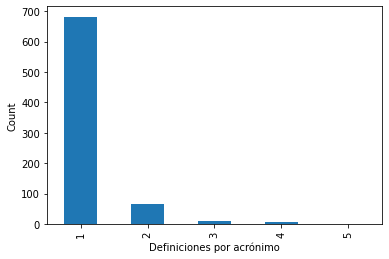

In [227]:
table = pd.crosstab(sf_lf_list['len'], columns = 'Count')
table.plot.bar(legend = None)
plt.xlabel("Definiciones por acrónimo")
plt.ylabel("Count")
#plt.show()
#plt.savefig('data/acron_count.png')

In [228]:
table = pd.crosstab(sf_lf_list['len'], columns = 'Count')
table

col_0,Count
len,
1,682
2,67
3,11
4,7
5,1


#### Apply Levenshtein distance to normalize Long Forms

Get more frequent lf per sf

In [229]:
frec = train['long_form'].value_counts().reset_index()
frec

,index,long_form
0,miligramo,404
1,decilitro,289
2,centimetro,235
3,litro,215
4,mililitro,180
...,...,...
776,anticuerpos noorgano especificos,1
777,eutectic mixture of local anesthetics,1
778,hiperplasia procesos coronoideos mandibulares,1
779,cuarto componente complemento,1


Create a dictionary where keys are the lf to normalize and the values the normalized form

In [230]:
norm = []
for i in sf_lf_list['long_form']:
    norm.append(normalize_lf(i))

In [231]:
norm = [i for i in norm if i != None]

In [232]:
norm_dict = {}
for i in norm:
    norm_dict.update(i)
#norm_dict

Finally normalize long forms over the dataframe

In [233]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


In [234]:
train = train.replace({"long_form": norm_dict})

Check that deffinitions have been normalized

In [235]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


### Get just ambigous acronyms

Execute this code just in case only ambigous acronyms are needed.

In [78]:
#amb = train.groupby('short_form')['long_form'].nunique().reset_index().sort_values('long_form', ascending = False)

In [79]:
#amb.head()

In [80]:
#table = pd.crosstab(amb['long_form'], columns = 'Count')
#table.plot.bar()
#plt.show()

In [81]:
#defin = amb[amb['long_form'] != 1]['short_form'].values.tolist()

In [82]:
#train.shape

In [83]:
#train = train[train['short_form'].isin(defin)]

In [84]:
#train.shape

### Add texts from Medline

Some long forms are imbalanced. Texts from Medline are added to improve balance.

In [236]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


Study imbalaced long forms. Number of rows for each different definition. We can see mostly long forms have just one row.

In [237]:
frec2 = train['long_form'].value_counts().reset_index()

In [238]:
train.long_form.nunique()

734

In [239]:
train[['doc_id','long_form']].drop_duplicates().shape

(2379, 2)

In [240]:
def_count = train[['doc_id','long_form']].drop_duplicates().groupby('long_form').agg({'doc_id':'count'}).reset_index()
def_count.sort_values('doc_id').tail()

,long_form,doc_id
467,milimetro,70
677,tomografia axial computarizada,71
191,decilitro,76
117,centimetro,111
463,miligramo,119


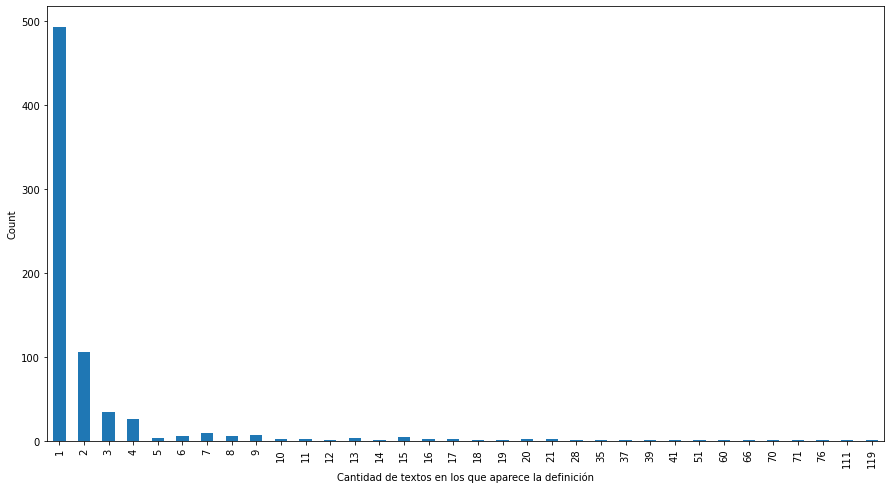

In [241]:
table = pd.crosstab(def_count['doc_id'], columns = 'Count')
table.plot.bar(legend = None, figsize=(15,8))
plt.xlabel("Cantidad de textos en los que aparece la definición")
plt.ylabel("Count")
#plt.savefig('data/def_count.png')
plt.show()

In [242]:
frec2[frec2['long_form'] == 1].head()

,index,long_form
368,articulacion temporomandibular,1
369,clostridium difficile infection,1
370,terminal deoxynucleotidyl transferase,1
371,endoscopic retrograde cholangiopancreatography,1
372,volume of distribution of urea,1


Let's find more text for definitions with 3 or less rows in train dataset.

In [243]:
train_lf = train.groupby('long_form').size().reset_index().rename(columns={0:'count'}).sort_values('count')
train_lf_list = train_lf[train_lf['count'] <= 3]['long_form'].unique().tolist()

In [244]:
len(train_lf_list)

541

List of deffinition to search in Medline

In [245]:
#sorted(train_lf_list)

#### Medline texts

In [246]:
medline = pd.read_csv("../../data/scrapping/textos_medline_scrapping2.csv")
medline.head()

,Unnamed: 0,url,text,concept
0,0,https://medlineplus.gov/spanish/mercury.html,"\n\nEl mercurio es un elemento que se encuentra en el aire, el agua y el suelo. Existe en varias...",mercurio
1,1,https://medlineplus.gov/spanish/ency/article/002476.htm,Este artículo aborda la intoxicación por mercurio.Este artículo es solamente informativo. NO lo ...,mercurio
2,2,https://medlineplus.gov/spanish/ency/article/002475.htm,Es una de las formas de mercurio. También es un tipo de sal de mercurio. Hay tipos diferentes de...,mercurio
3,3,https://medlineplus.gov/spanish/ency/article/002474.htm,El cloruro de mercurio es una forma muy tóxica de este elemento. Se trata de un tipo de sal de m...,mercurio
4,4,https://medlineplus.gov/spanish/ency/article/007763.htm,Es el daño al cerebro y al sistema nervioso causado por el químico metilmercurio. Este artículo ...,mercurio


In [247]:
medline[medline['concept'].isin(train_lf_list)]['concept'].nunique()

27

Just 30 deffinition have been find in Medline

In [248]:
medline[medline['concept'].isin(train_lf_list)].shape

(564, 4)

In [249]:
medline[medline['concept'].isin(train_lf_list)].head()

,Unnamed: 0,url,text,concept
0,0,https://medlineplus.gov/spanish/mercury.html,"\n\nEl mercurio es un elemento que se encuentra en el aire, el agua y el suelo. Existe en varias...",mercurio
1,1,https://medlineplus.gov/spanish/ency/article/002476.htm,Este artículo aborda la intoxicación por mercurio.Este artículo es solamente informativo. NO lo ...,mercurio
2,2,https://medlineplus.gov/spanish/ency/article/002475.htm,Es una de las formas de mercurio. También es un tipo de sal de mercurio. Hay tipos diferentes de...,mercurio
3,3,https://medlineplus.gov/spanish/ency/article/002474.htm,El cloruro de mercurio es una forma muy tóxica de este elemento. Se trata de un tipo de sal de m...,mercurio
4,4,https://medlineplus.gov/spanish/ency/article/007763.htm,Es el daño al cerebro y al sistema nervioso causado por el químico metilmercurio. Este artículo ...,mercurio


In [250]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
12,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


Transform Medline text with train structure

In [251]:
med_texts = medline[medline['concept'].isin(train_lf_list)]

In [252]:
med_texts = med_texts[['text', 'concept']].rename(columns = {'text':'texto', 'concept':'long_form'})

In [253]:
sf_lf = train[train['long_form'].isin(train_lf_list)][['short_form', 'long_form']].set_index('long_form').to_dict()['short_form']

In [254]:
med_texts['short_form'] = med_texts['long_form'].map(sf_lf)

In [255]:
def replace_sf_lf(row):
    row['texto'] = row['texto'].replace(row['long_form'], row['short_form'])
    return row['texto']

In [256]:
med_texts['texto'] = med_texts.apply(replace_sf_lf, axis = 1)

In [257]:
med_texts.head()

,texto,long_form,short_form
0,"\n\nEl Hg es un elemento que se encuentra en el aire, el agua y el suelo. Existe en varias forma...",mercurio,Hg
1,Este artículo aborda la intoxicación por Hg.Este artículo es solamente informativo. NO lo use pa...,mercurio,Hg
2,Es una de las formas de Hg. También es un tipo de sal de Hg. Hay tipos diferentes de intoxicació...,mercurio,Hg
3,El cloruro de Hg es una forma muy tóxica de este elemento. Se trata de un tipo de sal de Hg. Hay...,mercurio,Hg
4,Es el daño al cerebro y al sistema nervioso causado por el químico metilHg. Este artículo es sol...,mercurio,Hg


In [258]:
def find_offset(row):
    start_i = row['texto'].find(row['short_form'])
    end_i = start_i + len(row['short_form'])
    
    return start_i, end_i   

In [259]:
med_texts['offsets'] = med_texts.apply(find_offset, axis = 1)

In [260]:
med_texts[['StartOffset', 'EndOffset']] = pd.DataFrame(med_texts['offsets'].tolist(), index=med_texts.index)

In [261]:
med_texts = med_texts[['texto', 'short_form', 'long_form','StartOffset', 'EndOffset']]

In [262]:
med_texts.head()

,texto,short_form,long_form,StartOffset,EndOffset
0,"\n\nEl Hg es un elemento que se encuentra en el aire, el agua y el suelo. Existe en varias forma...",Hg,mercurio,5,7
1,Este artículo aborda la intoxicación por Hg.Este artículo es solamente informativo. NO lo use pa...,Hg,mercurio,41,43
2,Es una de las formas de Hg. También es un tipo de sal de Hg. Hay tipos diferentes de intoxicació...,Hg,mercurio,24,26
3,El cloruro de Hg es una forma muy tóxica de este elemento. Se trata de un tipo de sal de Hg. Hay...,Hg,mercurio,14,16
4,Es el daño al cerebro y al sistema nervioso causado por el químico metilHg. Este artículo es sol...,Hg,mercurio,72,74


Concat train and Medline texts

In [263]:
train.shape

(4865, 6)

In [264]:
train = pd.concat([train, med_texts], axis = 0)

In [265]:
train.shape

(5429, 6)

In [266]:
train.reset_index(inplace = True, drop = True)
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
4,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


Check how many deffinition have low texts

In [267]:
frec3 = train['long_form'].value_counts().reset_index()

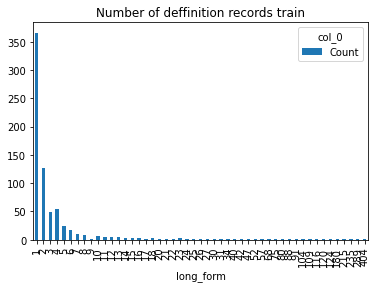

In [268]:
table = pd.crosstab(frec2['long_form'], columns = 'Count')
table.plot.bar()
plt.title('Number of deffinition records train')
plt.show()

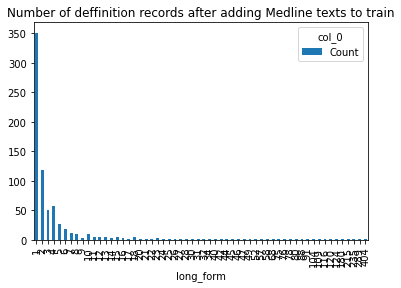

In [269]:
table = pd.crosstab(frec3['long_form'], columns = 'Count')
table.plot.bar()
plt.title('Number of deffinition records after adding Medline texts to train')
plt.show()

In [270]:
lf_low = set(train_lf_list)

In [271]:
lf_inmedline = set(medline[medline['concept'].isin(train_lf_list)]['concept'].unique().tolist())

In [272]:
#lf_low ^ lf_inmedline

Transform dataframe to a list of dictionaries

In [273]:
train_data = train[['doc_id', 'texto', 'short_form', 'long_form', 'StartOffset', 'EndOffset']].to_dict('records')

### Get the text before and after the SF

In [274]:
train_ndata, sf_not_found = get_f_b_context_text(train_data)

Check if any SF is not founded in the text

In [275]:
sf_not_found_set = set(sf_not_found)

In [276]:
len(sf_not_found_set)

15

Execute this code just in case clean the texts are needed: remove string punctuation, accents, lower case, remove double spaces, separate numbers from sf

In [277]:
# def clean_text_after(data):
    
#     for instance in data:
#         instance[1] = clean_text(instance[1]).lower()
#         instance[2] = clean_text(instance[2]).lower()
#         instance[1] = re.sub(r'(\d+)', r'\g<1> ', instance[1]) #metemos espacio entre número y acrónimos que quedan pegados    
#         instance[2] = re.sub(r'(\d+)', r'\g<1> ', instance[2])
#         instance[1] = re.sub(r'\s+', ' ', instance[1]).strip()
#         instance[2] = re.sub(r'\s+', ' ', instance[2]).strip()
#     return data
        

In [278]:
# train_ndata = clean_text_after(train_ndata)

### Get the contexts 

From the texts before and after the sf, we limit the number of words

In [279]:
star_ends_tokens = 6 #number of tokens to add because <start> and <end> labels 

In [280]:
n_step_f = 10 + star_ends_tokens #number of words to select from the forward context
n_step_b = 10 #number of words to select from the backward context

In [281]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/egarcia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [282]:
train_ndata = limit_context(train_ndata)

In [283]:
train_ndata[0]

['dl',
 'del líquido una glucorraquia normal , proteinorraquia de 102 mg/ < start > dl < end >',
 '960 células/mm3 un 90 % de las cuales se correspondían',
 'decilitro']

### Transform into df grouped by LF

In [284]:
data_dic = create_dict(train_ndata)

In [285]:
data_df = pd.DataFrame(data_dic)

Asign an id to each LF

In [286]:
data_df = data_df.assign(id=(data_df['long_form']).astype('category').cat.codes)

In [287]:
data_df.head()

,short_form,context,long_form,id
0,dl,"del líquido una glucorraquia normal , proteinorraquia de 102 mg/ < start > dl < end > 960 célula...",decilitro,191
1,dl,"que eran de 5,8 g/dl con albúmina de 1.400 mg/ < start > dl < end > El elemental de orina y sedi...",decilitro,191
2,dl,"67 y las proteínas totales que eran de 5,8 g/ < start > dl < end > con albúmina de 1.400 mg/dl ....",decilitro,191
3,dl,"las pruebas realizadas destacaba una anemia normocítica ( 9,9 g/ < start > dl < end > de Hb ) , ...",decilitro,191
4,g,"gamma-GT 67 y las proteínas totales que eran de 5,8 < start > g < end > dl con albúmina de 1.400...",gramo,313


In [288]:
data_df.shape

(5227, 4)

We will join each SF with all possible LFs, one for each record, so that later the model works in binary form assigning the probability that that is its LF

In [289]:
sf_lf_unique = data_df[['short_form', 'long_form']].drop_duplicates()

In [290]:
sf_lf_unique.shape

(834, 2)

In [291]:
sf_lf_unique.sort_values('short_form').head()

,short_form,long_form
4323,5-FU,5fluorouracilo
962,67Ga,gallium67
1802,99-MDP,99 metilendifosfonato
964,99Tc,tecnecio99
1557,A,adenina


In [292]:
data_merged = data_df.merge(sf_lf_unique, on = 'short_form', how = 'left')

In [293]:
data_merged.shape

(7207, 5)

In [294]:
pd.set_option('display.max_colwidth', 100)

In [295]:
data_df.sort_values(['short_form', 'context']).head()

,short_form,context,long_form,id
4325,5-FU,"1 , leucovorin 200 mg/m2 i.v . día 1 , < start > 5-FU < end > 400 mg/m2 en bolo i.v . día 1 , 5-FU",5fluorouracilo,1
4323,5-FU,"5-FU 400 mg/m2 en bolo i.v . día 1 , < start > 5-FU < end > 1.200 mg/m2/día en perfusión continu...",5fluorouracilo,1
4324,5-FU,"generalizada y alopecia , ambos relacionados con la toxicidad del < start > 5-FU < end > Pese a ...",5fluorouracilo,1
962,67Ga,"la cabeza femoral izquierda confirmada por TAC , 99Tc y < start > 67Ga < end > gammagrafía . La ...",gallium67,293
1802,99-MDP,realizado un estudio completo que incluyó gammagrafía ósea con tecnecio < start > 99-MDP < end >...,99 metilendifosfonato,2


In [296]:
data_merged.sort_values(['short_form', 'context']).head()

,short_form,context,long_form_x,id,long_form_y
5721,5-FU,"1 , leucovorin 200 mg/m2 i.v . día 1 , < start > 5-FU < end > 400 mg/m2 en bolo i.v . día 1 , 5-FU",5fluorouracilo,1,5fluorouracilo
5719,5-FU,"5-FU 400 mg/m2 en bolo i.v . día 1 , < start > 5-FU < end > 1.200 mg/m2/día en perfusión continu...",5fluorouracilo,1,5fluorouracilo
5720,5-FU,"generalizada y alopecia , ambos relacionados con la toxicidad del < start > 5-FU < end > Pese a ...",5fluorouracilo,1,5fluorouracilo
1265,67Ga,"la cabeza femoral izquierda confirmada por TAC , 99Tc y < start > 67Ga < end > gammagrafía . La ...",gallium67,293,gallium67
2464,99-MDP,realizado un estudio completo que incluyó gammagrafía ósea con tecnecio < start > 99-MDP < end >...,99 metilendifosfonato,2,99 metilendifosfonato


Target must be 1 or 0. 1 if the corresponding LF is the one assigned to it, 0 otherwise

In [297]:
data_merged['label'] = data_merged.apply(get_label, axis = 1)

In [298]:
data_merged.head()

,short_form,context,long_form_x,id,long_form_y,label
0,dl,"del líquido una glucorraquia normal , proteinorraquia de 102 mg/ < start > dl < end > 960 célula...",decilitro,191,decilitro,1
1,dl,"que eran de 5,8 g/dl con albúmina de 1.400 mg/ < start > dl < end > El elemental de orina y sedi...",decilitro,191,decilitro,1
2,dl,"67 y las proteínas totales que eran de 5,8 g/ < start > dl < end > con albúmina de 1.400 mg/dl ....",decilitro,191,decilitro,1
3,dl,"las pruebas realizadas destacaba una anemia normocítica ( 9,9 g/ < start > dl < end > de Hb ) , ...",decilitro,191,decilitro,1
4,g,"gamma-GT 67 y las proteínas totales que eran de 5,8 < start > g < end > dl con albúmina de 1.400...",gramo,313,gramo,1


In [299]:
data_merged = data_merged[['short_form', 'context', 'long_form_y', 'label']]

In [300]:
data_merged = data_merged.rename(columns = {'long_form_y':'long_form'})

In [301]:
data_merged.reset_index(drop = True, inplace = True)

In [302]:
data_merged.head()

,short_form,context,long_form,label
0,dl,"del líquido una glucorraquia normal , proteinorraquia de 102 mg/ < start > dl < end > 960 célula...",decilitro,1
1,dl,"que eran de 5,8 g/dl con albúmina de 1.400 mg/ < start > dl < end > El elemental de orina y sedi...",decilitro,1
2,dl,"67 y las proteínas totales que eran de 5,8 g/ < start > dl < end > con albúmina de 1.400 mg/dl ....",decilitro,1
3,dl,"las pruebas realizadas destacaba una anemia normocítica ( 9,9 g/ < start > dl < end > de Hb ) , ...",decilitro,1
4,g,"gamma-GT 67 y las proteínas totales que eran de 5,8 < start > g < end > dl con albúmina de 1.400...",gramo,1


In [303]:
data_merged.to_csv('../../data/data_train/train_data_beto_10_allacron_lfnorm_medline.csv')

## Prepare Dev Data

### Preprocessing

In [153]:
dev = dev_raw.merge(dev_abbr[['doc_id', 'Abbreviation', 'Definition']], on = 'doc_id', how = 'left')

In [154]:
dev = dev.merge(dev_abbr, on = ['doc_id', 'Abbreviation'], how = 'left')

In [155]:
dev = dev.drop_duplicates()

In [156]:
dev = dev[['doc_id', 'texto', 'Abbreviation', 'Definition_x', 'StartOffset', 'EndOffset']]

In [157]:
dev = dev.rename(columns = {'Definition_x':'Definition'})

In [158]:
dev.head()

,doc_id,texto,Abbreviation,Definition,StartOffset,EndOffset
0,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CEA,carcinoembrionary antigen,1796.0,1799.0
1,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MyO D1,myogenic differentiation 1,1759.0,1765.0
2,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CAM5.2,anticuerpo monoclonal de cytokeratina 5.2,1526.0,1532.0
3,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",AE1/AE3,anti-pan cytokeratin antibody,1515.0,1522.0
4,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MIB-1,mindbomb homolog 1,1322.0,1327.0


In [159]:
dev = dev.rename(columns = {'Abbreviation': 'short_form', 'Definition': 'long_form'})

In [160]:
dev = dev.dropna(subset = ['short_form', 'long_form'])

In [161]:
dev[['StartOffset', 'EndOffset']] = dev[['StartOffset', 'EndOffset']].astype(int)

Clean long forms to delete acents, string punctuation etc

In [162]:
dev['long_form'] = dev['long_form'].map(clean_text)

In [163]:
dev.head(3)

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CEA,carcinoembrionary antigen,1796,1799
1,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MyO D1,myogenic differentiation 1,1759,1765
2,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CAM5.2,anticuerpo monoclonal cytokeratina 52,1526,1532


### Normalize long forms

In [164]:
sf_lf = dev[['short_form', 'long_form']].drop_duplicates()

In [165]:
sf_lf.head()

,short_form,long_form
0,CEA,carcinoembrionary antigen
1,MyO D1,myogenic differentiation 1
2,CAM5.2,anticuerpo monoclonal cytokeratina 52
3,AE1/AE3,antipan cytokeratin antibody
4,MIB-1,mindbomb homolog 1


In [166]:
sf_lf_list = sf_lf.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list['len'] = sf_lf_list['long_form'].map(lambda x: len(x))
sf_lf_list.sort_values('len', ascending = False)

,short_form,long_form,len
291,T,"[temperatura, thymine, onda t]",3
183,L,"[linfocito, litro, leucocito]",3
125,G,"[gauge, guanine]",2
43,C3,"[tercera vertebra cervical, componente 3 complemento]",2
107,EPR,"[epitelio pigmentario retina, epitelio pigmentario retiniano]",2
...,...,...,...
155,HV,[hisventriculo],1
154,HTA,[hipertension arterial],1
153,HPP,[hipertension pulmonar],1
152,HPN,[hemoglobinuria paroxistica nocturna],1


Text(0, 0.5, 'Count')

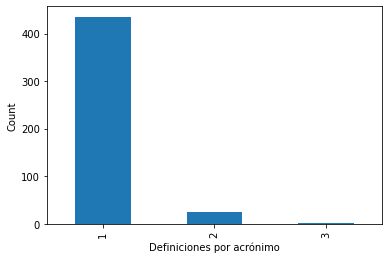

In [167]:
table = pd.crosstab(sf_lf_list['len'], columns = 'Count')
table.plot.bar(legend = None)
plt.xlabel("Definiciones por acrónimo")
plt.ylabel("Count")
#plt.show()
#plt.savefig('data/acron_count.png')

In [168]:
table = pd.crosstab(sf_lf_list['len'], columns = 'Count')
table

col_0,Count
len,
1,435
2,24
3,2


#### Apply Levenshtein distance to normalize Long Forms

Get more frequent lf per sf

In [169]:
frec = dev['long_form'].value_counts().reset_index()
frec

,index,long_form
0,miligramo,164
1,centimetro,110
2,litro,96
3,mililitro,88
4,decilitro,69
...,...,...
433,tiempo parcial tromboplastina activada,1
434,leucocito,1
435,basofilo,1
436,adenina adenina guanina timina,1


Create a dictionary where keys are the lf to normalize and the values the normalized form

In [170]:
norm = []
for i in sf_lf_list['long_form']:
    norm.append(normalize_lf(i))

In [171]:
norm = [i for i in norm if i != None]

In [172]:
norm_dict = {}
for i in norm:
    norm_dict.update(i)
#norm_dict

Finally normalize long forms over the dataframe

In [173]:
dev.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CEA,carcinoembrionary antigen,1796,1799
1,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MyO D1,myogenic differentiation 1,1759,1765
2,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CAM5.2,anticuerpo monoclonal cytokeratina 52,1526,1532
3,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",AE1/AE3,antipan cytokeratin antibody,1515,1522
4,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MIB-1,mindbomb homolog 1,1322,1327


In [174]:
dev = dev.replace({"long_form": norm_dict})

Check that deffinitions have been normalized

In [175]:
dev.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CEA,carcinoembrionary antigen,1796,1799
1,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MyO D1,myogenic differentiation 1,1759,1765
2,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CAM5.2,anticuerpo monoclonal cytokeratina 52,1526,1532
3,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",AE1/AE3,antipan cytokeratin antibody,1515,1522
4,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MIB-1,mindbomb homolog 1,1322,1327


### Get just ambigous acronyms

Execute this code just in case only ambigous acronyms are needed.

In [176]:
#amb = train.groupby('short_form')['long_form'].nunique().reset_index().sort_values('long_form', ascending = False)

In [177]:
#amb.head()

In [178]:
#table = pd.crosstab(amb['long_form'], columns = 'Count')
#table.plot.bar()
#plt.show()

In [179]:
#defin = amb[amb['long_form'] != 1]['short_form'].values.tolist()

In [180]:
#train.shape

In [181]:
#train = train[train['short_form'].isin(defin)]

In [182]:
#train.shape

### Add texts from Medline

Some long forms are imbalanced. Texts from Medline are added to improve balance.

In [183]:
dev.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CEA,carcinoembrionary antigen,1796,1799
1,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MyO D1,myogenic differentiation 1,1759,1765
2,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CAM5.2,anticuerpo monoclonal cytokeratina 52,1526,1532
3,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",AE1/AE3,antipan cytokeratin antibody,1515,1522
4,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MIB-1,mindbomb homolog 1,1322,1327


Study imbalaced long forms. Number of rows for each different definition. We can see mostly long forms have just one row.

In [184]:
frec2 = dev['long_form'].value_counts().reset_index()

In [185]:
dev.long_form.nunique()

434

In [186]:
dev[['doc_id','long_form']].drop_duplicates().shape

(1062, 2)

In [187]:
def_count = dev[['doc_id','long_form']].drop_duplicates().groupby('long_form').agg({'doc_id':'count'}).reset_index()
def_count.sort_values('doc_id').tail()

,long_form,doc_id
258,milimetro,30
390,tomografia axial computarizada,31
257,mililitro,34
66,centimetro,47
254,miligramo,48


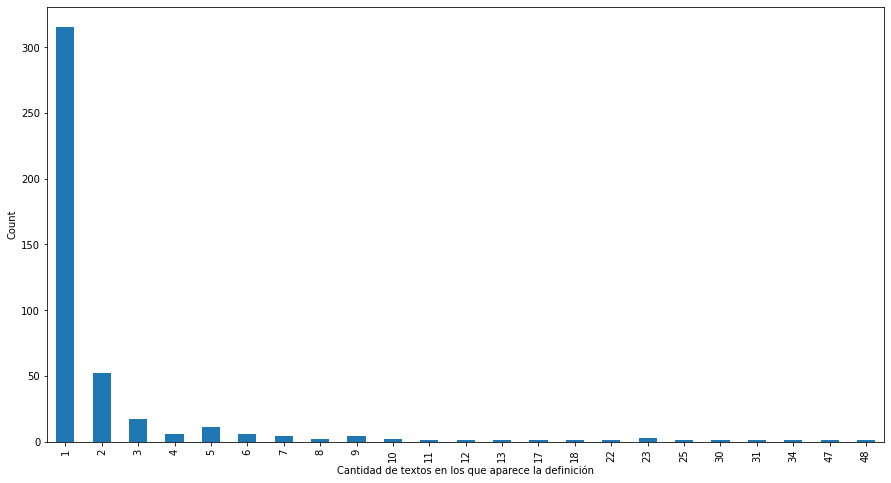

In [188]:
table = pd.crosstab(def_count['doc_id'], columns = 'Count')
table.plot.bar(legend = None, figsize=(15,8))
plt.xlabel("Cantidad de textos en los que aparece la definición")
plt.ylabel("Count")
#plt.savefig('data/def_count.png')
plt.show()

In [189]:
frec2[frec2['long_form'] == 1].head()

,index,long_form
201,alanina aminotransferasa,1
202,urografias resonancia nuclear magnetica,1
203,maxima apertura oral,1
204,queratitis ulcerativa periferica,1
205,segunda vertebra lumbar,1


Let's find more text for definitions with 3 or less rows in train dataset.

In [190]:
dev_lf = dev.groupby('long_form').size().reset_index().rename(columns={0:'count'}).sort_values('count')
dev_lf_list = dev_lf[dev_lf['count'] <= 3]['long_form'].unique().tolist()

In [191]:
len(dev_lf_list)

305

List of deffinition to search in Medline

In [367]:
#sorted(dev_lf_list)

#### Medline texts

In [193]:
medline = pd.read_csv("../data/scrapping/textos_medline_scrapping2.csv")
medline.head()

,Unnamed: 0,url,text,concept
0,0,https://medlineplus.gov/spanish/mercury.html,"\n\nEl mercurio es un elemento que se encuentra en el aire, el agua y el suelo. Existe en varias...",mercurio
1,1,https://medlineplus.gov/spanish/ency/article/002476.htm,Este artículo aborda la intoxicación por mercurio.Este artículo es solamente informativo. NO lo ...,mercurio
2,2,https://medlineplus.gov/spanish/ency/article/002475.htm,Es una de las formas de mercurio. También es un tipo de sal de mercurio. Hay tipos diferentes de...,mercurio
3,3,https://medlineplus.gov/spanish/ency/article/002474.htm,El cloruro de mercurio es una forma muy tóxica de este elemento. Se trata de un tipo de sal de m...,mercurio
4,4,https://medlineplus.gov/spanish/ency/article/007763.htm,Es el daño al cerebro y al sistema nervioso causado por el químico metilmercurio. Este artículo ...,mercurio


In [194]:
medline[medline['concept'].isin(dev_lf_list)]['concept'].nunique()

8

Just 8 deffinition have been find in Medline

In [195]:
medline[medline['concept'].isin(dev_lf_list)].shape

(199, 4)

In [196]:
medline[medline['concept'].isin(dev_lf_list)].head()

,Unnamed: 0,url,text,concept
38,38,https://medlineplus.gov/spanish/ency/article/003473.htm,Es un examen que mide el nivel de la enzima ALT en la sangre.\nSe necesita una muestra de sangre...,alanina aminotransferasa
39,39,https://medlineplus.gov/spanish/pruebas-de-laboratorio/prueba-de-ast/,"La AST (aspartato aminotransferasa) es una enzima que se encuentra principalmente en el hígado, ...",alanina aminotransferasa
40,40,https://medlineplus.gov/spanish/ency/article/003566.htm,La aldolasa es una proteína (llamada enzima) que ayuda a descomponer ciertos azúcares para produ...,alanina aminotransferasa
41,41,https://medlineplus.gov/spanish/pruebas-de-laboratorio/prueba-de-gamma-glutamil-transferasa-ggt/,La prueba de la gamma-glutamil transferasa (también conocida como gama-glutamiltransferasa o GGT...,alanina aminotransferasa
42,42,https://medlineplus.gov/spanish/pruebas-de-laboratorio/prueba-de-sangre-de-alt/,La alanina aminotransferasa o ALT es una enzima que se encuentra principalmente en el hígado. Cu...,alanina aminotransferasa


In [197]:
dev.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CEA,carcinoembrionary antigen,1796,1799
1,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MyO D1,myogenic differentiation 1,1759,1765
2,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CAM5.2,anticuerpo monoclonal cytokeratina 52,1526,1532
3,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",AE1/AE3,antipan cytokeratin antibody,1515,1522
4,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MIB-1,mindbomb homolog 1,1322,1327


Transform Medline text with train structure

In [198]:
med_texts = medline[medline['concept'].isin(dev_lf_list)]

In [199]:
med_texts = med_texts[['text', 'concept']].rename(columns = {'text':'texto', 'concept':'long_form'})

In [200]:
sf_lf = dev[dev['long_form'].isin(dev_lf_list)][['short_form', 'long_form']].set_index('long_form').to_dict()['short_form']

In [201]:
med_texts['short_form'] = med_texts['long_form'].map(sf_lf)

In [202]:
def replace_sf_lf(row):
    row['texto'] = row['texto'].replace(row['long_form'], row['short_form'])
    return row['texto']

In [203]:
med_texts['texto'] = med_texts.apply(replace_sf_lf, axis = 1)

In [204]:
med_texts.head()

,texto,long_form,short_form
38,Es un examen que mide el nivel de la enzima ALT en la sangre.\nSe necesita una muestra de sangre...,alanina aminotransferasa,A.L.T.
39,"La AST (aspartato aminotransferasa) es una enzima que se encuentra principalmente en el hígado, ...",alanina aminotransferasa,A.L.T.
40,La aldolasa es una proteína (llamada enzima) que ayuda a descomponer ciertos azúcares para produ...,alanina aminotransferasa,A.L.T.
41,La prueba de la gamma-glutamil transferasa (también conocida como gama-glutamiltransferasa o GGT...,alanina aminotransferasa,A.L.T.
42,La A.L.T. o ALT es una enzima que se encuentra principalmente en el hígado. Cuando las células h...,alanina aminotransferasa,A.L.T.


In [205]:
def find_offset(row):
    start_i = row['texto'].find(row['short_form'])
    end_i = start_i + len(row['short_form'])
    
    return start_i, end_i   

In [206]:
med_texts['offsets'] = med_texts.apply(find_offset, axis = 1)

In [207]:
med_texts[['StartOffset', 'EndOffset']] = pd.DataFrame(med_texts['offsets'].tolist(), index=med_texts.index)

In [208]:
med_texts = med_texts[['texto', 'short_form', 'long_form','StartOffset', 'EndOffset']]

In [209]:
med_texts.head()

,texto,short_form,long_form,StartOffset,EndOffset
38,Es un examen que mide el nivel de la enzima ALT en la sangre.\nSe necesita una muestra de sangre...,A.L.T.,alanina aminotransferasa,-1,5
39,"La AST (aspartato aminotransferasa) es una enzima que se encuentra principalmente en el hígado, ...",A.L.T.,alanina aminotransferasa,2598,2604
40,La aldolasa es una proteína (llamada enzima) que ayuda a descomponer ciertos azúcares para produ...,A.L.T.,alanina aminotransferasa,-1,5
41,La prueba de la gamma-glutamil transferasa (también conocida como gama-glutamiltransferasa o GGT...,A.L.T.,alanina aminotransferasa,-1,5
42,La A.L.T. o ALT es una enzima que se encuentra principalmente en el hígado. Cuando las células h...,A.L.T.,alanina aminotransferasa,3,9


Concat train and Medline texts

In [210]:
dev.shape

(2313, 6)

In [211]:
dev = pd.concat([dev, med_texts], axis = 0)

In [212]:
dev.shape

(2512, 6)

In [213]:
dev.reset_index(inplace = True, drop = True)
dev.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CEA,carcinoembrionary antigen,1796,1799
1,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MyO D1,myogenic differentiation 1,1759,1765
2,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",CAM5.2,anticuerpo monoclonal cytokeratina 52,1526,1532
3,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",AE1/AE3,antipan cytokeratin antibody,1515,1522
4,S0004-06142008000100008-1,"Presentamos el caso de una mujer de 30 años, fumadora de 20 cigarrillos/día y sin otros antecede...",MIB-1,mindbomb homolog 1,1322,1327


Check how many deffinition have low texts

In [214]:
frec3 = dev['long_form'].value_counts().reset_index()

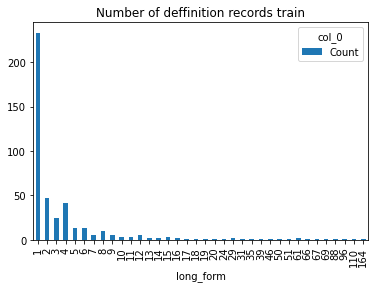

In [215]:
table = pd.crosstab(frec2['long_form'], columns = 'Count')
table.plot.bar()
plt.title('Number of deffinition records train')
plt.show()

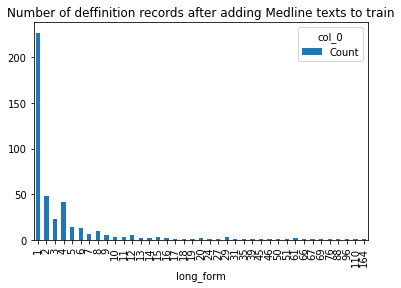

In [216]:
table = pd.crosstab(frec3['long_form'], columns = 'Count')
table.plot.bar()
plt.title('Number of deffinition records after adding Medline texts to train')
plt.show()

In [217]:
lf_low = set(dev_lf_list)

In [218]:
lf_inmedline = set(medline[medline['concept'].isin(dev_lf_list)]['concept'].unique().tolist())

In [368]:
#lf_low ^ lf_inmedline

Transform dataframe to a list of dictionaries

In [220]:
dev_data = dev[['doc_id', 'texto', 'short_form', 'long_form', 'StartOffset', 'EndOffset']].to_dict('records')

### Get the text before and after the SF

In [221]:
dev_ndata, sf_not_found = get_f_b_context_text(dev_data)

Check if any SF is not founded in the text

In [222]:
sf_not_found_set = set(sf_not_found)

In [223]:
len(sf_not_found_set)

4

Execute this code just in case clean the texts are needed: remove string punctuation, accents, lower case, remove double spaces, separate numbers from sf

In [224]:
# def clean_text_after(data):
    
#     for instance in data:
#         instance[1] = clean_text(instance[1]).lower()
#         instance[2] = clean_text(instance[2]).lower()
#         instance[1] = re.sub(r'(\d+)', r'\g<1> ', instance[1]) #metemos espacio entre número y acrónimos que quedan pegados    
#         instance[2] = re.sub(r'(\d+)', r'\g<1> ', instance[2])
#         instance[1] = re.sub(r'\s+', ' ', instance[1]).strip()
#         instance[2] = re.sub(r'\s+', ' ', instance[2]).strip()
#     return data
        

In [225]:
# train_ndata = clean_text_after(train_ndata)

### Get the contexts 

From the texts before and after the sf, we limit the number of words

In [226]:
star_ends_tokens = 6 #number of tokens to add because <start> and <end> labels 

In [227]:
n_step_f = 10 + star_ends_tokens #number of words to select from the forward context
n_step_b = 10 #number of words to select from the backward context

In [228]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/egarcia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [229]:
dev_ndata = limit_context(dev_ndata)

In [230]:
dev_ndata[0]

['CEA',
 ', MyO D1 y Calretinina ) , así como para < start > CEA < end >',
 'y citoqueratinas de alto peso molecular , observándose tan sólo',
 'carcinoembrionary antigen']

### Transform into df grouped by LF

In [231]:
data_dic = create_dict(dev_ndata)

In [232]:
data_df = pd.DataFrame(data_dic)

Asign an id to each LF

In [233]:
data_df = data_df.assign(id=(data_df['long_form']).astype('category').cat.codes)

In [234]:
data_df.head()

,short_form,context,long_form,id
0,CEA,", MyO D1 y Calretinina ) , así como para < start > CEA < end > y citoqueratinas de alto peso mol...",carcinoembrionary antigen,61
1,MyO D1,"a músculo liso ( actina de músculo liso , < start > MyO D1 < end > y Calretinina ) , así como pa...",myogenic differentiation 1,272
2,CAM5.2,observa marcada positividad frente a citoqueratinas ( AE1/AE3 ) y < start > CAM5.2 < end > a niv...,anticuerpo monoclonal cytokeratina 52,28
3,AE1/AE3,estudio inmunohistoquímico se observa marcada positividad frente a citoqueratinas ( < start > AE...,antipan cytokeratin antibody,34
4,MIB-1,de proliferación medido como positividad nuclear con anticuerpos frente a < start > MIB-1 < end ...,mindbomb homolog 1,266


In [235]:
data_df.shape

(2429, 4)

We will join each SF with all possible LFs, one for each record, so that later the model works in binary form assigning the probability that that is its LF

In [236]:
sf_lf_unique = data_df[['short_form', 'long_form']].drop_duplicates()

In [237]:
sf_lf_unique.shape

(485, 2)

In [238]:
sf_lf_unique.sort_values('short_form').head()

,short_form,long_form
2301,123I-MIBG,123imetayodobencilguanidina
1624,99mTc,tecnecio99m
1408,A,adenine
2303,A-H,intervalo conduccion ah
1048,A-LHRH,antagonist of luteinizing hormonereleasing hormone


In [239]:
data_merged = data_df.merge(sf_lf_unique, on = 'short_form', how = 'left')

In [240]:
data_merged.shape

(3040, 5)

In [241]:
pd.set_option('display.max_colwidth', 100)

In [242]:
data_df.sort_values(['short_form', 'context']).head()

,short_form,context,long_form,id
2301,123I-MIBG,"Fue remitido a Oncología Médica , donde solicitaron gammagrafía con < start > 123I-MIBG < end > ...",123imetayodobencilguanidina,0
1624,99mTc,cuello y cabeza femoral derecha . La gammagrafía ósea ( < start > 99mTc < end > constató el acúm...,tecnecio99m,372
2411,A,"El < start > A < end > N , o ácido desoxirribonucleico , es el material que",adenine,7
1408,A,"gen PAH : c.165delT ( p.Phe55fs ) / c.q62G > < start > A < end > ( p.Val388Met ) , siendo ambos ...",adenine,7
2303,A-H,procedió también a un estudio electrofisiológico el cual mostró intervalos < start > A-H < end >...,intervalo conduccion ah,211


In [243]:
data_merged.sort_values(['short_form', 'context']).head()

,short_form,context,long_form_x,id,long_form_y
2773,123I-MIBG,"Fue remitido a Oncología Médica , donde solicitaron gammagrafía con < start > 123I-MIBG < end > ...",123imetayodobencilguanidina,0,123imetayodobencilguanidina
1947,99mTc,cuello y cabeza femoral derecha . La gammagrafía ósea ( < start > 99mTc < end > constató el acúm...,tecnecio99m,372,tecnecio99m
3022,A,"El < start > A < end > N , o ácido desoxirribonucleico , es el material que",adenine,7,adenine
1706,A,"gen PAH : c.165delT ( p.Phe55fs ) / c.q62G > < start > A < end > ( p.Val388Met ) , siendo ambos ...",adenine,7,adenine
2775,A-H,procedió también a un estudio electrofisiológico el cual mostró intervalos < start > A-H < end >...,intervalo conduccion ah,211,intervalo conduccion ah


Target must be 1 or 0. 1 if the corresponding LF is the one assigned to it, 0 otherwise

In [244]:
data_merged['label'] = data_merged.apply(get_label, axis = 1)

In [245]:
data_merged.head()

,short_form,context,long_form_x,id,long_form_y,label
0,CEA,", MyO D1 y Calretinina ) , así como para < start > CEA < end > y citoqueratinas de alto peso mol...",carcinoembrionary antigen,61,carcinoembrionary antigen,1
1,MyO D1,"a músculo liso ( actina de músculo liso , < start > MyO D1 < end > y Calretinina ) , así como pa...",myogenic differentiation 1,272,myogenic differentiation 1,1
2,CAM5.2,observa marcada positividad frente a citoqueratinas ( AE1/AE3 ) y < start > CAM5.2 < end > a niv...,anticuerpo monoclonal cytokeratina 52,28,anticuerpo monoclonal cytokeratina 52,1
3,AE1/AE3,estudio inmunohistoquímico se observa marcada positividad frente a citoqueratinas ( < start > AE...,antipan cytokeratin antibody,34,antipan cytokeratin antibody,1
4,AE1/AE3,estudio inmunohistoquímico se observa marcada positividad frente a citoqueratinas ( < start > AE...,antipan cytokeratin antibody,34,monoclonal antibodies ae1 and ae3,0


In [246]:
data_merged = data_merged[['short_form', 'context', 'long_form_y', 'label']]

In [247]:
data_merged = data_merged.rename(columns = {'long_form_y':'long_form'})

In [248]:
data_merged.reset_index(drop = True, inplace = True)

In [249]:
data_merged.head()

,short_form,context,long_form,label
0,CEA,", MyO D1 y Calretinina ) , así como para < start > CEA < end > y citoqueratinas de alto peso mol...",carcinoembrionary antigen,1
1,MyO D1,"a músculo liso ( actina de músculo liso , < start > MyO D1 < end > y Calretinina ) , así como pa...",myogenic differentiation 1,1
2,CAM5.2,observa marcada positividad frente a citoqueratinas ( AE1/AE3 ) y < start > CAM5.2 < end > a niv...,anticuerpo monoclonal cytokeratina 52,1
3,AE1/AE3,estudio inmunohistoquímico se observa marcada positividad frente a citoqueratinas ( < start > AE...,antipan cytokeratin antibody,1
4,AE1/AE3,estudio inmunohistoquímico se observa marcada positividad frente a citoqueratinas ( < start > AE...,monoclonal antibodies ae1 and ae3,0


In [250]:
data_merged.to_csv('../data/data_train/dev_data_beto_10_allacron_lfnorm_medline.csv')

## Prepare Test Data

### Preprocessing

In [251]:
testing_raw.rename(columns={'nombre':'doc_id'}, inplace = True)

In [252]:
test = testing_raw.merge(testing_abbr[['doc_id', 'Abbreviation', 'Definition_lemmatized']], on = 'doc_id', how = 'left')

In [253]:
test = test.merge(testing_abbr, on = ['doc_id', 'Abbreviation'], how = 'left')

In [254]:
test = test.drop_duplicates()

In [255]:
test = test[['doc_id', 'texto', 'Abbreviation', 'Definition_lemmatized_x', 'StartOffset', 'EndOffset']]

In [256]:
test = test.rename(columns = {'Definition_lemmatized_x':'Definition'})

In [257]:
test.head()

,doc_id,texto,Abbreviation,Definition,StartOffset,EndOffset
0,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",AMA,antimitochondrial antibodie,673.0,676.0
1,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",AMA-2,anti-mitochondrial-2 antibody,678.0,683.0
2,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",ANA,antinuclear antibody,668.0,671.0
3,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",ANCA,antineutrophil cytoplasmic antibodie,685.0,689.0
4,S1130-01082008001000010-1,"Varón de 43 años originario de Marruecos, que ingresó en nuestro servicio por cuadro de 4 días d...",CA,carbohydrate antiger,622.0,624.0


In [258]:
test = test.rename(columns = {'Abbreviation': 'short_form', 'Definition': 'long_form'})

In [259]:
test = test.dropna(subset = ['short_form', 'long_form'])

In [260]:
test[['StartOffset', 'EndOffset']] = test[['StartOffset', 'EndOffset']].astype(int)

Clean long forms to delete acents, string punctuation etc

In [261]:
test['long_form'] = test['long_form'].map(clean_text)

### Normalize long forms

In [262]:
sf_lf_test = test[['short_form', 'long_form']].drop_duplicates()

In [263]:
sf_lf_list_test = sf_lf_test.groupby('short_form', as_index=False).agg({'long_form': list})
sf_lf_list_test['len'] = sf_lf_list_test['long_form'].map(lambda x: len(x))
sf_lf_list_test.sort_values('len', ascending = False)

,short_form,long_form,len
87,C3,"[tercero componente complemento, tercero vertebra cervical, complemento 3, nivel c subnivel 3]",4
241,G,"[gauge, guanine, guanina]",3
215,F,"[filamentous, fenilalanina, french]",3
481,T,"[treonina, thymus, onda t]",3
416,PL,"[puncion lumbar, percepcion luz, periodo lavado]",3
...,...,...,...
252,GOT,[glutamic oxalic transaminar],1
253,GPL,[g fosfolipido],1
254,GPT,[glutamate pyruvatar transaminar],1
255,GQ-1b,[antigangliosidir antibodie 1b],1


#### Apply Levenshtein distance to normalize Long Forms

Get more frequent lf per sf

In [264]:
frec = test['long_form'].value_counts().reset_index()
frec

,index,long_form
0,miligramo,361
1,decilitro,213
2,centimetro,171
3,litro,128
4,mililitro,117
...,...,...
673,functional analysis through hiddir markov models,1
674,hepatitis b superficie,1
675,epsteinbarr virusencoded rno,1
676,concentrated antibody for usar with biogenex supersensitivir detection systems,1


Create a dictionary where keys are the lf to normalize and the values the normalized form

In [265]:
norm_test = []
for i in sf_lf_list_test['long_form']:
    norm_test.append(normalize_lf(i))

In [266]:
norm_test = [i for i in norm_test if i != None]

In [267]:
norm_dict_test = {}
for i in norm_test:
    norm_dict_test.update(i)
#norm_dict

Finally normalize long forms over the dataframe

In [268]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
4,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


In [269]:
test = test.replace({"long_form": norm_dict_test})

In [270]:
train.head()

,doc_id,texto,short_form,long_form,StartOffset,EndOffset
0,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1908,1910
1,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1684,1686
2,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1656,1658
3,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",dl,decilitro,1414,1416
4,S1130-01082006000100014-1,"Se trata de una mujer de 35 años, con antecedentes familiares de enfermedad de Crohn y sin antec...",g,gramo,1654,1655


### Get just ambigous acronyms

Execute this code just in case only ambigous acronyms are needed.

In [271]:
#amb_test = test.groupby('short_form')['long_form'].nunique().reset_index().sort_values('long_form', ascending = False)

In [272]:
#amb_test.head()

In [273]:
#table = pd.crosstab(amb_test['long_form'], columns = 'Count')
#table.plot.bar()
#plt.show()

In [274]:
#defin_test = amb_test[amb_test['long_form'] != 1]['short_form'].values.tolist()

In [275]:
#test.shape

In [276]:
#test = test[test['short_form'].isin(defin_test)]

In [277]:
#test.shape

Transform dataframe to a list of dictionaries

In [278]:
test_data = test[['doc_id', 'texto', 'short_form', 'long_form', 'StartOffset', 'EndOffset']].to_dict('records')

### Get the text before and after the SF

In [279]:
test_ndata, sf_not_found = get_f_b_context_text(test_data)

Check if any SF is not founded in the text

In [280]:
sf_not_found_set = set(sf_not_found)

In [281]:
len(sf_not_found_set)

0

Execute this code just in case clean the texts are needed: remove string punctuation, accents, lower case, remove double spaces, separate numbers from sf

In [282]:
# def clean_text_after(data):
    
#     for instance in data:
#         instance[1] = clean_text(instance[1]).lower()
#         instance[2] = clean_text(instance[2]).lower()
#         instance[1] = re.sub(r'(\d+)', r'\g<1> ', instance[1]) #metemos espacio entre número y acrónimos que quedan pegados    
#         instance[2] = re.sub(r'(\d+)', r'\g<1> ', instance[2])
#         instance[1] = re.sub(r'\s+', ' ', instance[1]).strip()
#         instance[2] = re.sub(r'\s+', ' ', instance[2]).strip()
#     return data
        

In [283]:
# train_ndata = clean_text_after(train_ndata)

### Get the contexts 

From the texts before and after the sf, we limit the number of words

In [284]:
star_ends_tokens = 6 #number of tokens to add because <start> and <end> labels 

In [285]:
n_step_f = 10 + star_ends_tokens #number of words to select from the forward context
n_step_b = 10 #number of words to select from the backward context

In [286]:
test_ndata = limit_context(test_ndata)

In [287]:
test_ndata[0]

['AMA',
 'era de 82 UI/ml . Los autoanticuerpos ( ANA , < start > AMA < end >',
 'AMA-2 , ANCA , LKM1 , SMA , SLA y',
 'antimitochondrial antibodie']

### Transform into df grouped by LF

In [288]:
data_dic = create_dict(test_ndata)

In [289]:
data_df = pd.DataFrame(data_dic)

Asign an id to each LF

In [290]:
data_df = data_df.assign(id=(data_df['long_form']).astype('category').cat.codes)

In [291]:
data_df.head()

,short_form,context,long_form,id
0,AMA,"era de 82 UI/ml . Los autoanticuerpos ( ANA , < start > AMA < end > AMA-2 , ANCA , LKM1 , SMA , ...",antimitochondrial antibodie,47
1,AMA-2,"82 UI/ml . Los autoanticuerpos ( ANA , AMA , < start > AMA-2 < end > ANCA , LKM1 , SMA , SLA y F...",antimitochondrial2 antibody,48
2,ANA,"CA 19-9 era de 82 UI/ml . Los autoanticuerpos ( < start > ANA < end > AMA , AMA-2 , ANCA , LKM1 ...",antinuclear antibody,53
3,ANCA,". Los autoanticuerpos ( ANA , AMA , AMA-2 , < start > ANCA < end > LKM1 , SMA , SLA y F-actina )...",antineutrophil cytoplasmic antibodie,51
4,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end > 19-9 era de 82 UI/ml . Los...,carbohydrate antiger,97


In [292]:
data_df.shape

(3515, 4)

We will join each SF with all possible LFs, one for each record, so that later the model works in binary form assigning the probability that that is its LF

In [293]:
sf_lf_unique = data_df[['short_form', 'long_form']].drop_duplicates()

In [294]:
sf_lf_unique.shape

(757, 2)

In [295]:
sf_lf_unique.sort_values('short_form').head()

,short_form,long_form
1527,/mm3,milimetro cubico
2156,16SrRNA,16s ribosomal rno
1981,3D,3 dimension
2084,5-ASA,5aminosalicylic acid
2132,A,adenina


In [296]:
data_merged_test = data_df.merge(sf_lf_unique, on = 'short_form', how = 'left')

In [297]:
data_merged_test.shape

(4416, 5)

In [298]:
data_df.sort_values(['short_form', 'context']).head()

,short_form,context,long_form,id
1527,/mm3,mostró un líquido espeso de aspecto lechoso con 1400 leucocitos < start > /mm3 < end > con un 10...,milimetro cubico,411
2156,16SrRNA,los que se procedió al estudio genético mediante secuenciación del < start > 16SrRNA < end > ide...,16s ribosomal rno,0
1981,3D,con cuñas de compensación tisular tras simulación virtual y planificación < start > 3D < end > s...,3 dimension,1
2084,5-ASA,"endoscópicos , de colitis ulcerosa , se inicia tratamiento con < start > 5-ASA < end > a pesar d...",5aminosalicylic acid,2
1784,A,dominante ( ATR-AD ) . Dicha mutación ( c.1766G > < start > A < end > fig . 2A ) supone la susti...,adeniner,13


In [299]:
data_merged_test.sort_values(['short_form', 'context']).head()

,short_form,context,long_form_x,id,long_form_y
1883,/mm3,mostró un líquido espeso de aspecto lechoso con 1400 leucocitos < start > /mm3 < end > con un 10...,milimetro cubico,411,milimetro cubico
2688,16SrRNA,los que se procedió al estudio genético mediante secuenciación del < start > 16SrRNA < end > ide...,16s ribosomal rno,0,16s ribosomal rno
2472,3D,con cuñas de compensación tisular tras simulación virtual y planificación < start > 3D < end > s...,3 dimension,1,3 dimension
2588,5-ASA,"endoscópicos , de colitis ulcerosa , se inicia tratamiento con < start > 5-ASA < end > a pesar d...",5aminosalicylic acid,2,5aminosalicylic acid
2217,A,dominante ( ATR-AD ) . Dicha mutación ( c.1766G > < start > A < end > fig . 2A ) supone la susti...,adeniner,13,adeniner


Target must be 1 or 0. 1 if the corresponding LF is the one assigned to it, 0 otherwise

In [300]:
data_merged_test['label'] = data_merged_test.apply(get_label, axis = 1)

In [301]:
data_merged_test.head()

,short_form,context,long_form_x,id,long_form_y,label
0,AMA,"era de 82 UI/ml . Los autoanticuerpos ( ANA , < start > AMA < end > AMA-2 , ANCA , LKM1 , SMA , ...",antimitochondrial antibodie,47,antimitochondrial antibodie,1
1,AMA-2,"82 UI/ml . Los autoanticuerpos ( ANA , AMA , < start > AMA-2 < end > ANCA , LKM1 , SMA , SLA y F...",antimitochondrial2 antibody,48,antimitochondrial2 antibody,1
2,ANA,"CA 19-9 era de 82 UI/ml . Los autoanticuerpos ( < start > ANA < end > AMA , AMA-2 , ANCA , LKM1 ...",antinuclear antibody,53,antinuclear antibody,1
3,ANCA,". Los autoanticuerpos ( ANA , AMA , AMA-2 , < start > ANCA < end > LKM1 , SMA , SLA y F-actina )...",antineutrophil cytoplasmic antibodie,51,antineutrophil cytoplasmic antibodie,1
4,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end > 19-9 era de 82 UI/ml . Los...,carbohydrate antiger,97,carbohydrate antiger,1


In [302]:
data_merged_test = data_merged_test[['short_form', 'context', 'long_form_y', 'label']]

In [303]:
data_merged_test = data_merged_test.rename(columns = {'long_form_y':'long_form'})

In [304]:
data_merged_test.reset_index(drop = True, inplace = True)

In [305]:
data_merged_test.head()

,short_form,context,long_form,label
0,AMA,"era de 82 UI/ml . Los autoanticuerpos ( ANA , < start > AMA < end > AMA-2 , ANCA , LKM1 , SMA , ...",antimitochondrial antibodie,1
1,AMA-2,"82 UI/ml . Los autoanticuerpos ( ANA , AMA , < start > AMA-2 < end > ANCA , LKM1 , SMA , SLA y F...",antimitochondrial2 antibody,1
2,ANA,"CA 19-9 era de 82 UI/ml . Los autoanticuerpos ( < start > ANA < end > AMA , AMA-2 , ANCA , LKM1 ...",antinuclear antibody,1
3,ANCA,". Los autoanticuerpos ( ANA , AMA , AMA-2 , < start > ANCA < end > LKM1 , SMA , SLA y F-actina )...",antineutrophil cytoplasmic antibodie,1
4,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end > 19-9 era de 82 UI/ml . Los...,carbohydrate antiger,1


In [306]:
data_merged_test.to_csv('../data/data_train/test_data_beto_10_allacronim_lfnorm_medline.csv')

## Analize acronyms included in train and test

In [307]:
data_merged.head(3)

,short_form,context,long_form,label
0,CEA,", MyO D1 y Calretinina ) , así como para < start > CEA < end > y citoqueratinas de alto peso mol...",carcinoembrionary antigen,1
1,MyO D1,"a músculo liso ( actina de músculo liso , < start > MyO D1 < end > y Calretinina ) , así como pa...",myogenic differentiation 1,1
2,CAM5.2,observa marcada positividad frente a citoqueratinas ( AE1/AE3 ) y < start > CAM5.2 < end > a niv...,anticuerpo monoclonal cytokeratina 52,1


In [308]:
data_merged_test.head(3)

,short_form,context,long_form,label
0,AMA,"era de 82 UI/ml . Los autoanticuerpos ( ANA , < start > AMA < end > AMA-2 , ANCA , LKM1 , SMA , ...",antimitochondrial antibodie,1
1,AMA-2,"82 UI/ml . Los autoanticuerpos ( ANA , AMA , < start > AMA-2 < end > ANCA , LKM1 , SMA , SLA y F...",antimitochondrial2 antibody,1
2,ANA,"CA 19-9 era de 82 UI/ml . Los autoanticuerpos ( < start > ANA < end > AMA , AMA-2 , ANCA , LKM1 ...",antinuclear antibody,1


In [309]:
merged = data_merged_test.merge(data_merged, on = 'short_form', indicator = True, how = 'left')

In [310]:
merged.head()

,short_form,context_x,long_form_x,label_x,context_y,long_form_y,label_y,_merge
0,AMA,"era de 82 UI/ml . Los autoanticuerpos ( ANA , < start > AMA < end > AMA-2 , ANCA , LKM1 , SMA , ...",antimitochondrial antibodie,1,NaN,NaN,NaN,left_only
1,AMA-2,"82 UI/ml . Los autoanticuerpos ( ANA , AMA , < start > AMA-2 < end > ANCA , LKM1 , SMA , SLA y F...",antimitochondrial2 antibody,1,NaN,NaN,NaN,left_only
2,ANA,"CA 19-9 era de 82 UI/ml . Los autoanticuerpos ( < start > ANA < end > AMA , AMA-2 , ANCA , LKM1 ...",antinuclear antibody,1,proteína C reactiva ( PCR ) y anticuerpos antinucleares ( < start > ANA < end > . Todos los valo...,antinuclear antibody,1.0,both
3,ANCA,". Los autoanticuerpos ( ANA , AMA , AMA-2 , < start > ANCA < end > LKM1 , SMA , SLA y F-actina )...",antineutrophil cytoplasmic antibodie,1,", anti-SCL70 , anti-Jo , anticuerpos anticitoplasma de neutrófilos ( < start > ANCA < end > nega...",antineutrophil cytoplasmic antibodies,1.0,both
4,CA,IgG 1840 UI/ml ( 751-1.560 UI/ml ) . El marcador < start > CA < end > 19-9 era de 82 UI/ml . Los...,carbohydrate antiger,1,hifema que ocupa la mitad de la cámara anterior ( < start > CA < end > y sinequias posteriores 3...,camara anterior,1.0,both


In [311]:
merged[merged['_merge'] == 'left_only'].shape

(928, 8)

In [312]:
data_merged_test.shape

(4416, 4)

In [369]:
#sorted(merged[merged['_merge'] == 'left_only']['short_form'].unique().tolist())